In [13]:
import re
from pathlib import Path
import numpy as np

# Regex to match file names like A2V.asc, B5V.asc, etc. (case-insensitive)
PATTERN = re.compile(r'^[OBAFGKM][1-8]V\.asc$', re.IGNORECASE)

def load_spectra_from_folder(folder):
    """
    Scan `folder` for files matching the pattern and load two-column ASCII files.
    Returns a dict keyed by file stem (e.g., 'A2V') with values:
      {'wl': numpy_array, 'flux': numpy_array, 'path': str(path)}
    """
    folder = Path(folder)
    spectra = {}
    for f in folder.glob('*.asc'):
        if not PATTERN.match(f.name):
            continue
        # Try to read two first columns, allow for header/comments
        data = np.genfromtxt(f, usecols=(0, 1), comments='#', autostrip=True)
        if data.size == 0:
            # empty or unreadable file
            print(f"Warning: no numeric data in {f}")
            continue
        # Ensure shape is (N,2)
        if data.ndim == 1:
            if data.size < 2:
                print(f"Warning: unexpected data shape in {f}")
                continue
            data = data.reshape(-1, 2)
        # Remove rows with NaNs
        mask = ~np.isnan(data).any(axis=1)
        data = data[mask]
        if data.size == 0:
            print(f"Warning: all rows contain NaN in {f}")
            continue
        wl = data[:, 0].astype(float)
        flux = data[:, 1].astype(float)
        spectra[f.stem] = {'wl': wl, 'flux': flux, 'path': str(f)}
    return spectra

# Example usage:
if __name__ == '__main__':
    folder = r"C:\path\to\your\hostfolder"  # change this
    spectra = load_spectra_from_folder(folder)
    for name, d in spectra.items():
        print(name, d['wl'].shape, d['flux'].shape)

In [14]:
# Save all spectra to a compressed .npz file in a safe two-step way
to_save = {}
for name, d in spectra.items():
    to_save[f"{name}_wl"] = d['wl']
    to_save[f"{name}_flux"] = d['flux']
np.savez_compressed('spectra_archive.npz', **to_save)

# Example load:
# data = np.load('spectra_archive.npz')
# wl = data['A2V_wl'] ; flux = data['A2V_flux']

## Load spectra from folder

Run the loader to find files like `A2V.asc`, `B3V.asc`, etc., and load them into `spectra`.

In [15]:
# Set the folder and load spectra (change path if needed)
folder = r"C:\Users\olive\Desktop\Astro 4 Exercise 2"
spectra = load_spectra_from_folder(folder)
print(f"Loaded {len(spectra)} spectra from {folder}")
for name, d in sorted(spectra.items()):
    print(name, d['wl'].size, 'points —', d['path'])

Loaded 12 spectra from C:\Users\olive\Desktop\Astro 4 Exercise 2
A2V 2799 points — C:\Users\olive\Desktop\Astro 4 Exercise 2\A2V.asc
A6V 2799 points — C:\Users\olive\Desktop\Astro 4 Exercise 2\A6V.asc
B1V 2799 points — C:\Users\olive\Desktop\Astro 4 Exercise 2\B1V.asc
B6V 2799 points — C:\Users\olive\Desktop\Astro 4 Exercise 2\B6V.asc
F5V 2799 points — C:\Users\olive\Desktop\Astro 4 Exercise 2\F5V.asc
G2V 2799 points — C:\Users\olive\Desktop\Astro 4 Exercise 2\G2V.asc
G6V 2799 points — C:\Users\olive\Desktop\Astro 4 Exercise 2\G6V.asc
K4V 2799 points — C:\Users\olive\Desktop\Astro 4 Exercise 2\K4V.asc
M1V 2799 points — C:\Users\olive\Desktop\Astro 4 Exercise 2\M1V.asc
M5V 2799 points — C:\Users\olive\Desktop\Astro 4 Exercise 2\M5V.asc
O5V 2799 points — C:\Users\olive\Desktop\Astro 4 Exercise 2\O5V.asc
O8V 2799 points — C:\Users\olive\Desktop\Astro 4 Exercise 2\O8V.asc


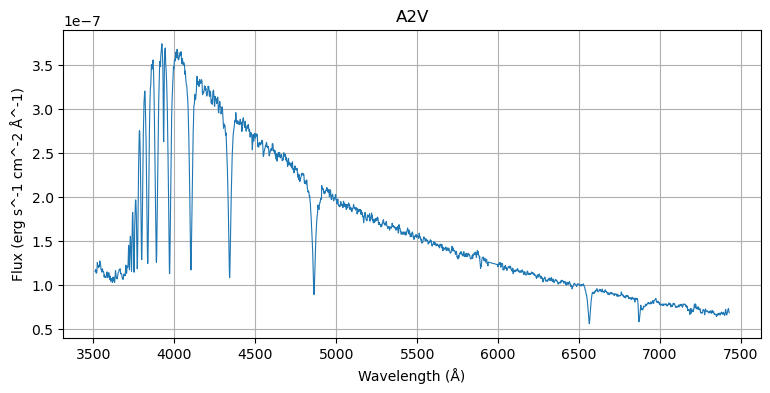

In [16]:
# Quick plot of the first spectrum (matplotlib)
import matplotlib.pyplot as plt
if len(spectra) == 0:
    print('No spectra loaded — check the folder/path and filename pattern')
else:
    name = next(iter(spectra))
    wl = spectra[name]['wl']
    flux = spectra[name]['flux']
    plt.figure(figsize=(9,4))
    plt.plot(wl, flux, lw=0.8)
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux (erg s^-1 cm^-2 Å^-1)')
    plt.title(name)
    plt.grid(True)
    plt.show()

In [17]:
# Optional: interactive dropdown to choose a spectrum (requires ipywidgets)
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt

    if len(spectra) == 0:
        print('No spectra to select.')
    else:
        dropdown = widgets.Dropdown(options=sorted(spectra.keys()), description='Spectrum:')
        out = widgets.Output()

        def on_change(change):
            if change['type'] == 'change' and change['name'] == 'value':
                with out:
                    clear_output(wait=True)
                    n = change['new']
                    wl = spectra[n]['wl']
                    flux = spectra[n]['flux']
                    plt.figure(figsize=(9,4))
                    plt.plot(wl, flux, lw=0.8)
                    plt.xlabel('Wavelength (Å)')
                    plt.ylabel('Flux (erg s^-1 cm^-2 Å^-1)')
                    plt.title(n)
                    plt.grid(True)
                    plt.show()

        dropdown.observe(on_change)
        display(dropdown, out)

except Exception as e:
    print('To enable interactive selection install ipywidgets:')
    print('    pip install ipywidgets')
    print('Then enable notebook extension if needed (classic notebook). Error:', e)

Dropdown(description='Spectrum:', options=('A2V', 'A6V', 'B1V', 'B6V', 'F5V', 'G2V', 'G6V', 'K4V', 'M1V', 'M5V…

Output()